In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# LOAD DATASET

data = pd.read_csv('/content/salt_content_ham2.csv', index_col=0)
#list_indexs = range(27,51)
#data.drop(data.index[list_indexs], inplace=True )
data.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band166,band167,band168,band169,band170,band171,band172,band173,band174,band175,band176,band177,band178,band179,band180,band181,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200,band201,band202,band203,band204,Salt
0,0.284257,0.249366,0.224309,0.204326,0.189497,0.178146,0.168257,0.161248,0.156066,0.152212,0.151211,0.150631,0.151228,0.152658,0.154468,0.158017,0.162693,0.169900,0.179311,0.191782,0.206518,0.222880,0.238954,0.253321,0.264941,0.274780,0.282382,0.288850,0.293855,0.297357,0.300356,0.302323,0.303226,0.302797,0.301361,0.299102,0.295090,0.289988,0.284497,0.278643,...,0.599777,0.597311,0.592720,0.592226,0.590146,0.587629,0.586358,0.583562,0.580570,0.580976,0.580756,0.579069,0.573715,0.564316,0.559719,0.551200,0.546305,0.536669,0.523635,0.514454,0.496554,0.481439,0.464671,0.454910,0.447460,0.439703,0.443198,0.440819,0.441426,0.444226,0.447807,0.454861,0.462858,0.463716,0.476962,0.481532,0.486014,0.495068,0.488017,0.638805
1,0.270824,0.235305,0.205166,0.185430,0.169601,0.156309,0.146676,0.139072,0.132898,0.128366,0.125784,0.124773,0.124631,0.125255,0.127025,0.130183,0.135811,0.144856,0.157015,0.171990,0.188481,0.205405,0.220431,0.233400,0.243523,0.251829,0.258105,0.263511,0.267327,0.270165,0.272409,0.274093,0.274762,0.274245,0.272791,0.270269,0.266898,0.261931,0.256305,0.249884,...,0.567561,0.567241,0.562912,0.558638,0.557357,0.559004,0.554983,0.556571,0.554733,0.551858,0.552624,0.547153,0.547268,0.543281,0.535359,0.527531,0.518662,0.509499,0.497064,0.488047,0.477087,0.457340,0.446723,0.431659,0.425746,0.418401,0.416223,0.421391,0.423170,0.426699,0.431991,0.439993,0.440340,0.452060,0.456321,0.473419,0.481597,0.490299,0.474413,0.767233
2,0.278932,0.237543,0.210911,0.187438,0.170400,0.157867,0.146440,0.138468,0.132184,0.127973,0.125123,0.124107,0.123518,0.124138,0.126056,0.129579,0.134933,0.142960,0.154179,0.168224,0.183836,0.200099,0.214733,0.228150,0.238526,0.247011,0.253934,0.259285,0.263165,0.266350,0.268065,0.269584,0.270116,0.269848,0.268055,0.265270,0.261016,0.255810,0.250018,0.243660,...,0.553628,0.551502,0.546533,0.542771,0.544095,0.541492,0.540686,0.537493,0.538715,0.535109,0.534906,0.532947,0.527755,0.522534,0.513509,0.504774,0.499655,0.489901,0.476717,0.467132,0.454792,0.434966,0.423924,0.409028,0.402215,0.401214,0.399388,0.398295,0.405985,0.410002,0.414244,0.414589,0.423431,0.434509,0.439365,0.456173,0.462708,0.472729,0.478105,0.650742
3,0.349498,0.300779,0.267037,0.240654,0.222573,0.209150,0.197557,0.189338,0.183519,0.180260,0.177848,0.177565,0.179057,0.182248,0.186112,0.192047,0.199558,0.209456,0.220454,0.231573,0.243741,0.256001,0.265874,0.275083,0.282048,0.288127,0.293460,0.297550,0.300659,0.303754,0.305330,0.306870,0.306984,0.307392,0.306742,0.305925,0.304587,0.303333,0.301692,0.299763,...,0.666414,0.664083,0.657284,0.655227,0.652786,0.649246,0.647446,0.647423,0.643480,0.638418,0.637725,0.629901,0.628168,0.617321,0.613350,0.605871,0.597793,0.590860,0.584667,0.571188,0.559929,0.545512,0.529075,0.520599,0.507498,0.507024,0.504764,0.511156,0.512751,0.516891,0.521007,0.530230,0.529855,0.541250,0.558598,0.562306,0.582928,0.578221,0.579865,0.579592
4,0.268250,0.229010,0.201534,0.179562,0.162913,0.151118,0.141468,0.133970,0.128221,0.125406,0.124370,0.124205,0.125311,0.127329,0.130545,0.135687,0.142395,0.151566,0.162930,0.176004,0.190546,0.205352,0.218807,0.230478,0.240058,0.247565,0.254205,0.259046,0.263039,0.266196,0.268510,0.269912,0.271006,0.271005,0.270351,0.267976,0.264787,0.261201,0.256790,0.252332,...,0.548775,0.547060,0.541290,0.540355,0.538287,0.539126,0.537786,0.534858,0.532186,0.532248,0.531701,0.525738,0.524216,0.515223,0.510580,0.

In [ ]:
y = data['Salt'].values
X = data.values[:,:-1]
print(X.shape)
print(y.shape)

(104, 204)
(104,)


In [ ]:
# DATA PRE-PROCESSING
# Multiplicative scatter corection
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

# Standard normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):

        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])

    return output_data


# Apply corrections
Xmsc = msc(X)[0] # Take the first element of the output tuple
Xsnv = snv(Xmsc)

# Apply smoothing
from scipy.signal import savgol_filter
X1snv = savgol_filter(Xsnv, 9, polyorder = 2, deriv=1)

In [ ]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
import tensorflow as tf
import random
import numpy as np


# Prepare data 
X1 = X1snv.reshape(X1snv.shape[0], X1snv.shape[1], 1)
y = y.reshape(y.shape[0],1)

In [ ]:
#Hot fix for pickeable tensorflow
import pickle
import tempfile
from tensorflow.keras.models import Sequential, load_model, save_model, Model

# Hotfix function
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

# Run the function
make_keras_picklable()

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score
tf.get_logger().setLevel('ERROR')
def baseline_model():
    model = Sequential()

    model.add(Conv1D(filters=256, input_shape=(204,1), kernel_size=3, padding='same', activation='relu',
                     activity_regularizer=keras.regularizers.l2(0.001)))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu',
                     activity_regularizer=keras.regularizers.l2(0.001)))
    model.add(Conv1D(filters=64, kernel_size=7, activation='relu',
                     activity_regularizer=keras.regularizers.l2(0.001)))
    model.add(Conv1D(filters=32, kernel_size=9, activation='relu',
                     activity_regularizer=keras.regularizers.l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(100,
                    activation='relu', 
                    kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.1))
    model.add(Dense(50, 
                    activation='relu', 
                    kernel_regularizer=keras.regularizers.l2(0.02)))
    model.add(Dense(1,
                    activation='linear'))#, 
                    #kernel_regularizer=keras.regularizers.l1_l2(0.01)))
    
    adam = tf.keras.optimizers.Adam(learning_rate=0.0009,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-07,
                                    amsgrad=False,
                                    name="Adam")

    model.compile(loss='mse', optimizer=adam)
    return model

seed_value = 1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

X1 = X1snv.reshape(X1snv.shape[0], X1snv.shape[1], 1)
y = y.reshape(y.shape[0],1)

kfold = KFold(n_splits=20, shuffle=True, random_state=seed_value)

estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, batch_size=5, verbose=0)
history = estimator.fit(X1,y)
# Save to file in the current working directory
pkl_filename = "/content/pickle_cnn_model.pkl"
with open(pkl_filename, 'wb') as file:
  pickle.dump(estimator.model, file)
print("Model Saved! aleluia!!!")
#y_pred = estimator.predict(X1)
#print('CALIB R2: ', r2_score(y, y_pred))

#results = cross_val_score(estimator, X1, y , cv=kfold)
#print(f'{results.mean()} +- {results.std()}')

#predicted = cross_val_predict(estimator, X1, y, cv=kfold)
#print('CV R2: ', r2_score(y, predicted))

#z = np.polyfit(y.reshape(y.shape[0]), predicted, 1)
#fig, ax = plt.subplots()
#ax.scatter(y, y_pred)
#ax.plot(z[1]+z[0]*y, y, c='blue', lw=2)
#ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
#ax.set_xlabel('Measured')
#ax.set_ylabel('Predicted')
#plt.show()

Model Saved! aleluia!!!


In [ ]:
#print(r2_score(y, predicted))


In [ ]:
# SAVE MODEL AFTER TRAINNING WITH ALL DATA AVAILABLE
#import pickle
history = estimator.fit(X1,y)
filename = '/content/drive/MyDrive/Colab Notebooks/salt_prediction_model_final.h5'
estimator.model.save(filepath=filename)


In [ ]:
z = np.polyfit(y.reshape(y.shape[0]), predicted, 1)
fig, ax = plt.subplots()
ax.scatter(y, y_pred)
ax.plot(z[1]+z[0]*y, y, c='blue', lw=2)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(results)
plt.show()

In [ ]:
!pip install spectral

     |████████████████████████████████| 215kB 5.7MB/s 


In [ ]:
import numpy as np
import pandas as pd
from spectral import *
import cv2
from tensorflow.keras.models import Sequential, load_model, save_model, Model
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, normalize

In [ ]:
#LOAD DATA

img = open_image("/content/REFLECTANCE_2020-07-16_003.hdr")
data = img.load()

(200, 400, 204)


ImageView object:
  Display bands       :  (150, 30, 12)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1.199430227279663]
    G: [0.0, 1.197396993637085]
    B: [0.0, 1.3955659866333008]

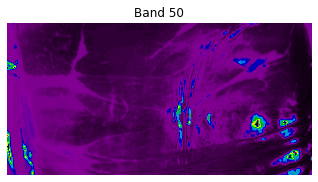

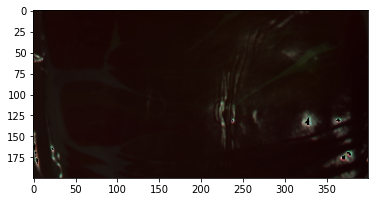

In [ ]:
fig = plt.figure(figsize = (12,6))

crop = data[300:500,100:500]
print(crop.shape)
for i in range(1, 1 + 1):
    fig.add_subplot(1,2, i) #grid 2 by 4
    q = 50#np.random.randint(dat.shape[2]) # Choose a random band 
    plt.imshow(crop.read_band(q), cmap='nipy_spectral')
    plt.axis('off')
    plt.title('Band ' + str(q))

imshow(crop, (150, 30, 12))

Mask:  (200, 400, 1)


ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1.0]
    G: [0.0, 1.0]
    B: [0.0, 1.0]

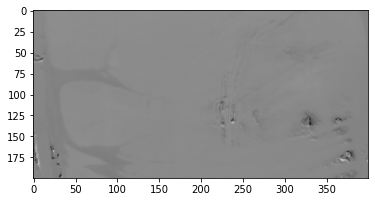

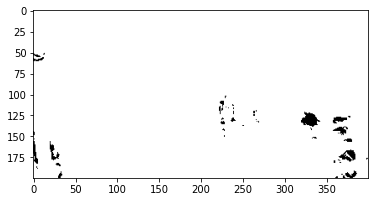

In [ ]:
low_ref= crop[:,:,10]
high_ref = crop[:,:,150]
m_ref = high_ref - low_ref
imshow(m_ref)
# Thresholding binarization
mask = np.uint8(m_ref > 0.02)
print("Mask: ", mask.shape)
imshow(mask)

In [ ]:
contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("Contours found:", len(contours))

Contours found: 1


In [ ]:
def max_contour(cnts):
    rect_index = 0
    max_area = 0

    for index in range(len(cnts)):
        area = cv2.contourArea(cnts[index])
        if area > max_area:
            max_area = area
            rect_index = index 
    return cnts[rect_index]

In [ ]:
if len(contours) > 0:
        cnt = max_contour(contours)
        area = cv2.contourArea(cnt)
        print("Area: ", area)
        if area > 500:
            is_ham_present = True
            # Mask application
            for i in range(0,crop.shape[2]):
                crop[:,:,i] = crop[:,:,i] * mask

Area:  79102.0


In [ ]:
def extract_pixels(input_data):
    d = input_data.reshape(-1,input_data.shape[2])
    df = pd.DataFrame(data=d)
    df.columns = [f'band{i}' for i in range(1, 1+d.shape[1])]
    print(df.head())
    return df
pixels = extract_pixels(crop)

      band1     band2     band3  ...   band202   band203   band204
0  0.083770  0.075314  0.069686  ...  0.161677  0.161290  0.151079
1  0.089005  0.075314  0.069686  ...  0.161677  0.167742  0.158273
2  0.089005  0.075314  0.069686  ...  0.161677  0.154839  0.158273
3  0.083770  0.079498  0.073171  ...  0.161677  0.161290  0.158273
4  0.083770  0.075314  0.073171  ...  0.161677  0.161290  0.151079

[5 rows x 204 columns]


In [ ]:
# cleans all masked pixels
def clean_null_pixels(dataframe):
    return dataframe[(dataframe.T != 0.0).any()]
ham_pixels = clean_null_pixels(pixels)
ham_pixels.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band165,band166,band167,band168,band169,band170,band171,band172,band173,band174,band175,band176,band177,band178,band179,band180,band181,band182,band183,band184,band185,band186,band187,band188,band189,band190,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200,band201,band202,band203,band204
0,0.083770,0.075314,0.069686,0.068657,0.067885,0.064516,0.063786,0.061111,0.058626,0.057927,0.056865,0.058302,0.058343,0.058950,0.055446,0.060886,0.061909,0.062247,0.063359,0.063128,0.063946,0.063226,0.063113,0.062427,0.063333,0.063886,0.064271,0.062500,0.064426,0.064385,0.065510,0.066779,0.069371,0.071737,0.072948,0.076103,0.078872,0.082492,0.084550,0.085857,...,0.130172,0.130705,0.126731,0.125137,0.126840,0.130688,0.132121,0.128625,0.131854,0.132432,0.130070,0.130246,0.129518,0.131661,0.135621,0.133106,0.133452,0.133581,0.133981,0.135903,0.138298,0.138393,0.136150,0.138614,0.139108,0.138504,0.144118,0.145963,0.148026,0.142857,0.148148,0.154150,0.147679,0.152466,0.149758,0.154639,0.155556,0.161677,0.161290,0.151079
1,0.089005,0.075314,0.069686,0.068657,0.067885,0.062212,0.061728,0.061111,0.060302,0.056402,0.056865,0.059569,0.058343,0.058950,0.058416,0.061808,0.062769,0.062247,0.064122,0.065280,0.065986,0.065161,0.063725,0.064761,0.063333,0.062830,0.064271,0.063953,0.064893,0.065286,0.067245,0.068459,0.069749,0.071737,0.074468,0.076471,0.078872,0.083188,0.084550,0.086522,...,0.132190,0.132780,0.132055,0.132821,0.131370,0.129522,0.132121,0.131148,0.129243,0.133784,0.134266,0.133140,0.132530,0.134796,0.133987,0.133106,0.131673,0.131725,0.139806,0.137931,0.140426,0.140625,0.140845,0.138614,0.139108,0.138504,0.144118,0.142857,0.141447,0.143357,0.151852,0.150198,0.151899,0.152466,0.149758,0.154639,0.150000,0.161677,0.167742,0.158273
2,0.089005,0.075314,0.069686,0.068657,0.067885,0.064516,0.061728,0.061111,0.058626,0.059451,0.059639,0.060837,0.060677,0.061093,0.058416,0.062731,0.061909,0.063056,0.063359,0.065997,0.065986,0.066452,0.064338,0.063594,0.065000,0.064414,0.063765,0.063953,0.065826,0.065736,0.065944,0.068459,0.070183,0.072913,0.074088,0.077941,0.079943,0.081448,0.085569,0.087188,...,0.131181,0.130705,0.126731,0.129528,0.127973,0.128355,0.129697,0.127364,0.129243,0.131081,0.131469,0.131693,0.131024,0.133229,0.132353,0.129693,0.131673,0.131725,0.132039,0.133874,0.138298,0.140625,0.138498,0.138614,0.141732,0.144044,0.144118,0.145963,0.144737,0.146853,0.148148,0.146245,0.151899,0.147982,0.149758,0.154639,0.166667,0.161677,0.154839,0.158273
3,0.083770,0.079498,0.073171,0.068657,0.067885,0.066820,0.061728,0.061111,0.061977,0.059451,0.058252,0.059569,0.057176,0.058950,0.059406,0.060886,0.061909,0.062247,0.061832,0.063845,0.062585,0.063226,0.063113,0.063594,0.063333,0.063358,0.064777,0.064438,0.064426,0.065286,0.065510,0.066359,0.069371,0.070561,0.074088,0.075368,0.078515,0.081100,0.083871,0.086855,...,0.132190,0.130705,0.127796,0.128430,0.131370,0.129522,0.128485,0.129887,0.130548,0.131081,0.132867,0.131693,0.131024,0.130094,0.133987,0.131399,0.135231,0.133581,0.133981,0.133874,0.138298,0.138393,0.136150,0.138614,0.136483,0.141274,0.141176,0.142857,0.144737,0.143357,0.151852,0.150198,0.147679,0.147982,0.149758,0.159794,0.161111,0.161677,0.161290,0.158273
4,0.083770,0.075314,0.073171,0.068657,0.067885,0.066820,0.061728,0.061111,0.060302,0.059451,0.059639,0.058302,0.059510,0.060021,0.060396,0.059963,0.059329,0.061439,0.063359,0.063845,0.064626,0.063871,0.064951,0.063594,0.061667,0.062830,0.064777,0.063953,0.063959,0.065736,0.066377,0.067619,0.068154,0.071737,0.074848,0.077574,0.079229,0.082840,0.085908,0.087521,...,0.131181,0.128631,0.127796,0.127333,0.129105,0.128355,0.132121,0.129887,0.129243,0.131081,0.130070,0.130246,0.131024,0.130094,0.132353

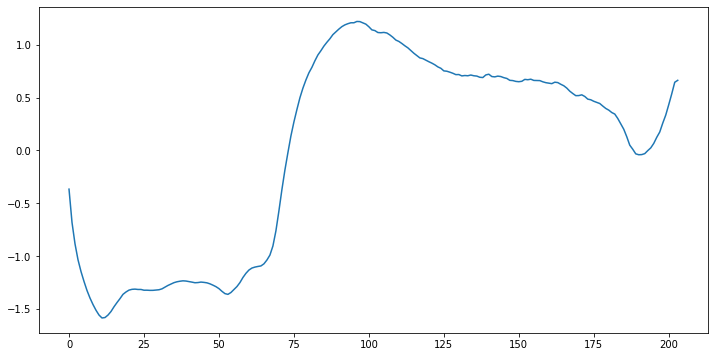

(1, 204)


In [ ]:
# Gets spectral info of ham in general
def get_spectral_signature(dataframe):
    X = dataframe.to_numpy()#values[:,:-1]
    Xmsc = msc(X)[0] # Take the first element of the output tuple
    Xsnv = snv(Xmsc)
    return np.mean(Xsnv, axis=0)
spectrum = get_spectral_signature(ham_pixels)
fig2 = plt.figure(figsize = (12,6))
plt.plot(spectrum)
plt.show()
spectrum  = spectrum.reshape(1,spectrum.shape[0])
print(spectrum.shape)

In [ ]:
#1. Smoothing
from scipy.signal import savgol_filter
x = savgol_filter(spectrum, 9, polyorder = 2, deriv=1)

#2. Prediction
model_path = '/content/drive/MyDrive/Colab Notebooks/salt_prediction_model_final.h5'
model = load_model(model_path)

X1 = x.reshape(x.shape[0], x.shape[1], 1)

In [ ]:

print("Ham %: ", model.predict(X1)[0][0])

Ham %:  9.632817
